In [2]:
################ SINGLE BOTTLENECK #######################

from matplotlib import pyplot as plt
import errno

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os, subprocess
import pandas as pd

import threading

g_log_scale = ""

In [3]:
def plot_cwnd_vs_time_individual(noOfSources = 2, RTTs = "10ms" , Flavours= "TcpBbr", log_scale = 0, part = 0):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/cwndDropTail.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')
    
    data = data.T
    data = data.iloc[1:]
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
   
    # Just plot normally
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), (source_data.iloc[i, start_index:end_index]))

        
    plt.plot(range(start_index, end_index), average_values[start_index:end_index], linestyle='--', color = "gold", label="average cwnd")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("Cwnd (abs)")
    plt.title(f"Cwnd vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
     
def plot_cwnd_vs_time_individual_averaged_per_flavour(noOfSources = 2, RTTs = "10ms" , Flavours= "TcpBbr", log_scale = 0, part = 0):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/cwndDropTail.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')
    
    data = data.T
    data = data.iloc[1:]
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values_all = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
   
    Flavours_values = Flavours.split('_')
    noOfFlowWithSimilarFlavours = int(noOfSources/len(Flavours_values))
    noOfPlots = len(Flavours_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        # Using pos to find which Flavours this flow belongs to
        pos = int(i/noOfFlowWithSimilarFlavours)
        
        # Only y values need to be average, the x values (time) is already known
        y_values[pos].append(source_data.iloc[i, start_index:end_index])
        
    # Plotting for each Flavours    
    for p in range(noOfPlots):    
        average_values = [sum(pair) / len(pair) for pair in zip(*y_values[p])]
        plt.plot(range(start_index, end_index),average_values, label = Flavours_values[p])
    
        
    plt.plot(range(start_index, end_index), average_values_all[start_index:end_index], linestyle='--', color = "gold", label="average cwnd")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("Cwnd (abs)")
    plt.title(f"Cwnd vs time (averaged per flavour)   Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
 
def plot_dropped_vs_time( noOfSources = 2, RTTs = "10ms" , Flavours= "TcpBbr", log_scale = 0, part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
     
     
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/droppedPacketTrace.txt", "r") as f:
        lines = f.readlines()
        prev = 0
        
        for line in lines:
            split_line = line.split()
            droppedpvstime[int(split_line[0])] = int(split_line[1])-prev;
            prev = int(split_line[1])

    if ( part > 0):
        data_length = len(droppedpvstime.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(droppedpvstime.keys())[start_index:], list(droppedpvstime.values())[start_index:])
        # # Save data to a .prn file
        # with open(f"prn/packetloss_RTT{RTTs[:-2]}.prn", "w") as output_file:
        #     output_file.write("P\tT\n")
        #     for time, packetloss in list(droppedpvstime.items())[start_index:]:
        #         output_file.write(f"{packetloss}\t{time}\n")
    else:
        plt.plot(list(droppedpvstime.keys()), list(droppedpvstime.values()))
    
    plt.xlabel("time")
    plt.ylabel("Packet Dropped" + g_log_scale)
    plt.title(f"Packet Dropped vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
    f.close()
        
    
def plot_btl_utilization_vs_time_individual(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/btlnck_throughput.txt"
    
    # The bottlenecks are fixed for now (Should be in Mbps)
    capacities= [100]
    
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    data = data.T
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = data_length
    else:
        start_index = 0
        end_index = len(source_data.iloc[0]) - 20
        
    # Plot a graph for each Source ID within the specified range
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), ((source_data.iloc[i, start_index:end_index]/capacities[i])*100))

    plt.xlabel("time")
    plt.ylabel("Link utilization (%)")
    plt.title(f"Bottleneck Link utilization (%) vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")

def plot_qsize_vs_time( noOfSources = 2, RTTs = "10ms" , Flavours= "TcpBbr", maxQSize = "2084p", log_scale = 0, part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
      
    
    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/qsizeTrace.txt", "r") as f:
        lines = f.readlines()
    
    for line in lines:
        split_line = line.split()
        
        qutilvstime[float(split_line[0])] = float(split_line[1]);

    plt.axhline(y = int(maxQSize[0:-1]), color='r')
    
    if ( part > 0):
        data_length = len(qutilvstime.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(qutilvstime.keys())[start_index:], list(qutilvstime.values())[start_index:])
        # # Save data to a .prn file
        # with open(f"prn/queue_RTT{RTTs[:-2]}.prn", "w") as output_file:
        #     output_file.write("Q\tT\n")
        #     for time, qsize in list(qutilvstime.items())[start_index:]:
        #         output_file.write(f"{qsize}\t{time}\n")
    
    else:
        plt.plot(qutilvstime.keys(), qutilvstime.values())
    
            
    plt.xlabel("time")
    plt.ylabel("Q size (abs) " + g_log_scale)
    plt.title(f"Q size vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
    f.close()
    
def plot_dest_throughput_vs_time_averaged_per_rtt(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/dest_throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')
    data = data.T
    
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)
    
    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
        
    RTT_values = RTTs.split('_')
    noOfFlowWithSimilarRTT = int(noOfSources/len(RTT_values))
    noOfPlots = len(RTT_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        # Using pos to find which RTT this flow belongs to
        pos = int(i/noOfFlowWithSimilarRTT)
        
        # Only y values need to be average, the x values (time) is already known
        y_values[pos].append(source_data.iloc[i, start_index:end_index])
        
    # Plotting for each RTT    
    for p in range(noOfPlots):    
        average_values = [sum(pair) / len(pair) for pair in zip(*y_values[p])]
        plt.plot(range(start_index, end_index),average_values, label = RTT_values[p])
    
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Throughput Dest vs time averaged per RTT    Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
    
def plot_dest_lost_packets_vs_time_summed_per_flavour(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/droppedPacketTrace.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    data = data.T
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
        
    Flavours_values = Flavours.split('_')
    noOfFlowWithSimilarFlavours = int(noOfSources/len(Flavours_values))
    noOfPlots = len(Flavours_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        # Using pos to find which Flavours this flow belongs to
        pos = int(i/noOfFlowWithSimilarFlavours)
        
        # Only y values need to be average, the x values (time) is already known
        y_values[pos].append(source_data.iloc[i, start_index:end_index])
        
    # Plotting for each Flavours    
    for p in range(noOfPlots):    
        average_values = [sum(pair) for pair in zip(*y_values[p])]
        plt.plot(range(start_index, end_index),average_values, label = Flavours_values[p])
    
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("Packets Lost")
    plt.title(f"Packets Lost vs time summed per Flavour   Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")


def plot_dest_throughput_vs_time_averaged_per_flavour(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/dest_throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    data = data.T
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
        
    Flavours_values = Flavours.split('_')
    noOfFlowWithSimilarFlavours = int(noOfSources/len(Flavours_values))
    noOfPlots = len(Flavours_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        # Using pos to find which Flavours this flow belongs to
        pos = int(i/noOfFlowWithSimilarFlavours)
        
        # Only y values need to be average, the x values (time) is already known
        y_values[pos].append(source_data.iloc[i, start_index:end_index])
        
    # Plotting for each Flavours    
    for p in range(noOfPlots):    
        average_values = [sum(pair) / len(pair) for pair in zip(*y_values[p])]
        plt.plot(range(start_index, end_index),average_values, label = Flavours_values[p])
    
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Throughput Dest vs time averaged per Flavour   Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")


def plot_dest_throughput_vs_time_individual(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/dest_throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    data = data.T
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Extract Source IDs and their corresponding values
    source_ids = data.index
    source_data = data
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
   
    # # Just plot normally
    # for i, source_id in enumerate(source_ids):
    #     plt.plot(range(start_index, end_index), (source_data.iloc[i, start_index:end_index]))

        
    plt.plot(range(start_index, end_index), average_values[start_index:end_index], linestyle='--', label="Avg. throughput", color = "gold")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Throughput Dest vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")

def plot_btlnck_throughput_vs_time_individual(noOfSources=2, RTTs="10ms", Flavours="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSources}/btlnck_throughput.txt"
    
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')
    
    # Read data from the file
    data = data.T
    data = data.iloc[1:]
    
    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    
    source_ids = data.index
    source_data = data
    

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = data_length
    else:
        start_index = 0
        end_index = len(source_data.iloc[0]) - 20
    
    # Plot a graph for each Source ID within the specified range
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), source_data.iloc[i, start_index:end_index])

    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Bottleneck Throughput vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavours:{Flavours}")
    

def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTTs = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTTs));
    
    

In [4]:
def main(Flavours = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth = 100, 
         bottleneck_delay = 1 , RTTs = "10ms", packetSize = 1458, queueL = "5p", noOfSource = 2, 
         rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0, SRBuffers = "off", log_scale = 0, run_simul = "no", part = 0, build_profile = 'debug', disableCwndTracing = False):
     if build_profile not in ["debug", "optimized"]:
         print("build-profile:", build_profile, " not found!")
         return
     
     if queueL[-3:] == "BDP":
          if len(RTTs.split('_')) > 1:
              return "Can't use BDP queue size with multiple RTTs."
          queueL = float(queueL[0:-3])*((float(bottleneck_bandwidth[0:-4]) * (10**6) * float(RTTs[0:-2]) * 10**(-3))/8)/packetSize
          queueL = str(int(queueL))+'p'
          print ( "Queue Size: ",queueL )
     
     
     if log_scale == 1:
          g_log_scale = "log"
          plt.yscale("log")
     else:
          g_log_scale = ""
     
     
     # access_link_delay_val = RTTs[0:-2]
     access_link_bandwidth_val = total_access_bandwidth[0:-4]
     
     #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
     access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
     
     # lock = threading.Lock();
     
     
     # lock.acquire();   
     # Creating new directory structure to isolate 2 different processes and their output
     try: 
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{Flavours}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{Flavours}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSource}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{Flavours}/{RTTs}/{noOfSource}")
     except OSError as exc:
          if exc.errno != errno.EEXIST:
               raise
          pass
     
     # lock.release();
    
     # if os.path.exists("/mnt/Store/Project-summer/runtime"):
     #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")
          
     cmd = f'''./ns3 run \"scratch/tcp_ftp_n_rtts --nSources={noOfSource} 
     --flavours={Flavours} --bottleneckBandwidth={bottleneck_bandwidth} 
     --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
     --queueSize={queueL} --pktSize={packetSize} 
     --simDuration={time}  --rtts={RTTs} --disableCwndTracing={disableCwndTracing}\"'''
     cmd_change_build_profile = f'./ns3 configure --build-profile={build_profile} --enable-examples --enable-test --disable-werror'
     #--command-template=\"gdb --args %s <args>\"
     
     if run_simul == "yes":
         # Change build_profile only if not only configured
          if subprocess.run("./ns3 show profile", shell=True, capture_output=True, text=True).stdout.split()[2] != build_profile:
              os.system(cmd_change_build_profile)
          os.system(cmd)
     
     plot_qsize_vs_time(noOfSource, RTTs, Flavours, queueL, log_scale = log_scale, part = part, total_time = time)
     plot_dest_throughput_vs_time_individual(noOfSource, RTTs, Flavours, part = part)
     # if len(RTTs.split('_')) > 1:
     #      plot_dest_throughput_vs_time_averaged_per_rtt(noOfSource, RTTs, Flavours, part = part)
          
     if len(Flavours.split('_')) > 1:
          plot_dest_throughput_vs_time_averaged_per_flavour(noOfSource, RTTs, Flavours, part = part)
     
     
     #plot_btlnck_throughput_vs_time_individual(noOfSource, RTTs, Flavours, part = part)
     plot_btl_utilization_vs_time_individual(noOfSource, RTTs, Flavours, part = part)
     
     if disableCwndTracing is False:
          plot_cwnd_vs_time_individual(noOfSource, RTTs, Flavours, log_scale = log_scale, part = part)
          #plot_cwnd_vs_time_individual_averaged_per_flavour(noOfSource, RTTs, Flavours, log_scale = log_scale, part = part)
          
     plot_dest_lost_packets_vs_time_summed_per_flavour(noOfSource, RTTs, Flavours, part = part)
     
 

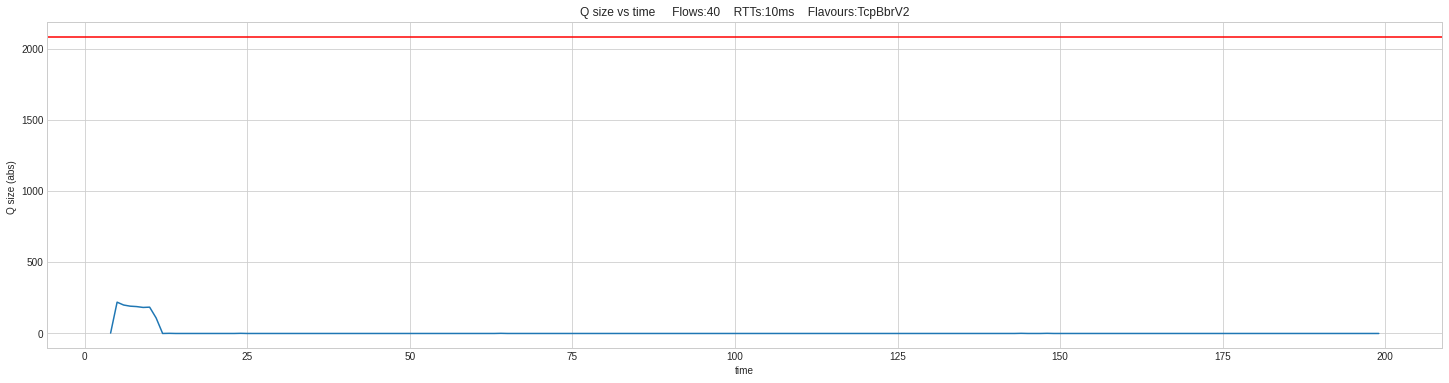

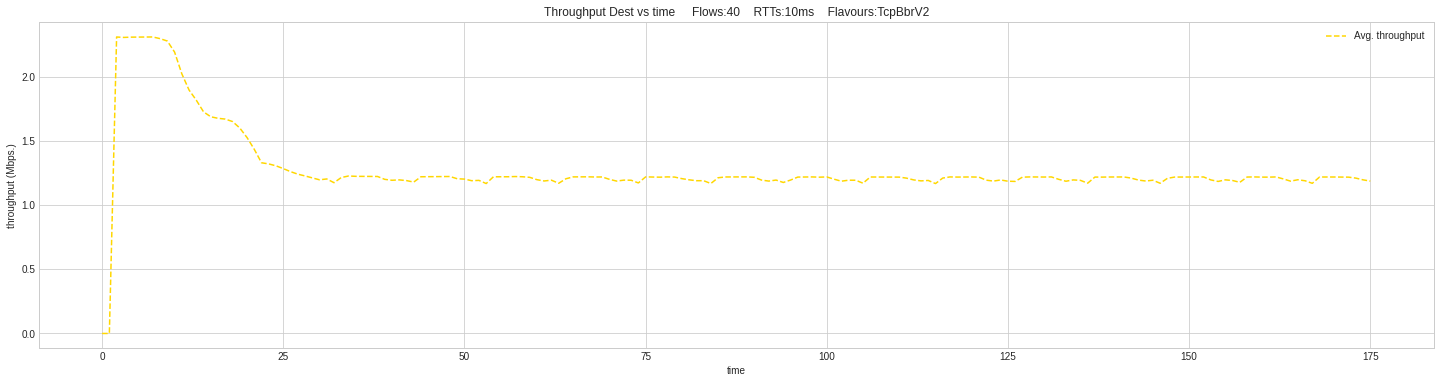

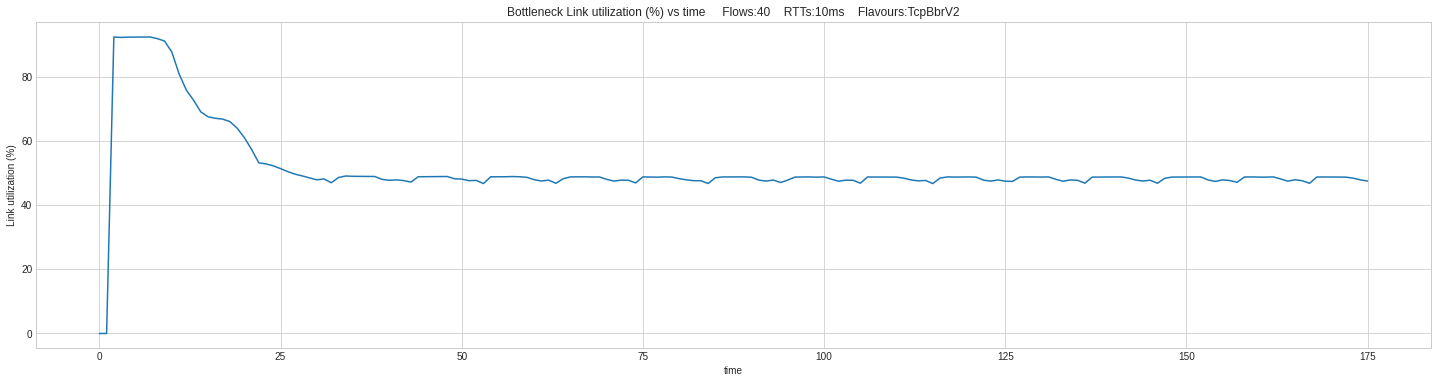

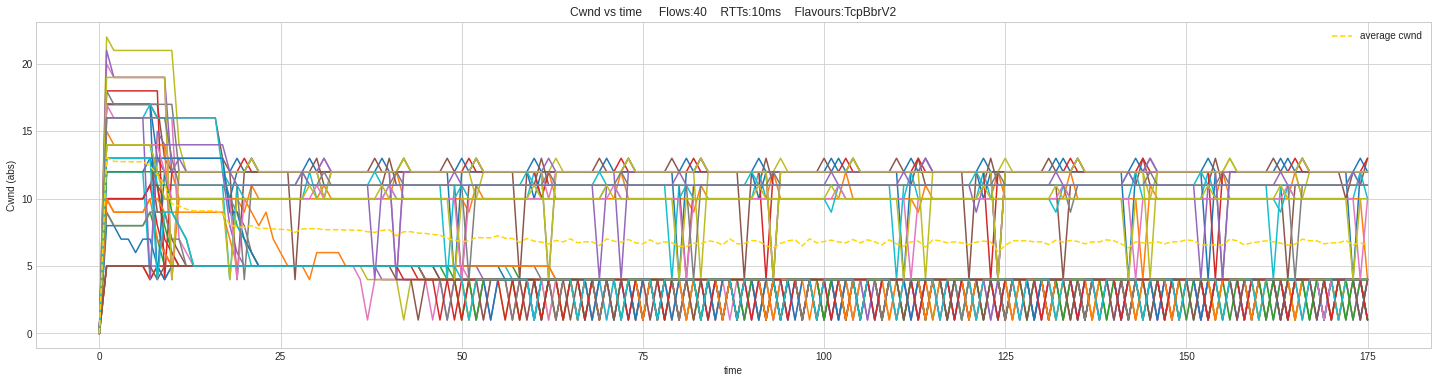

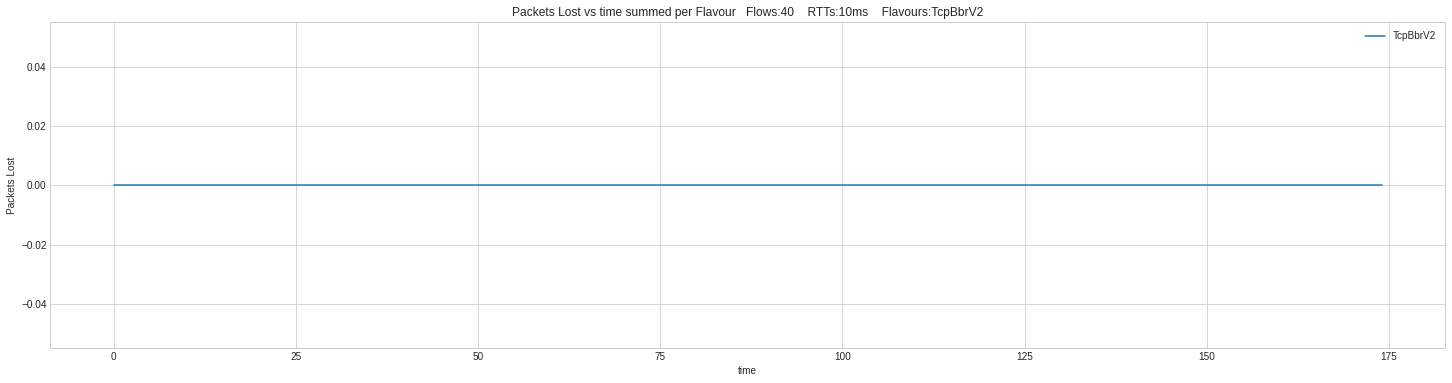

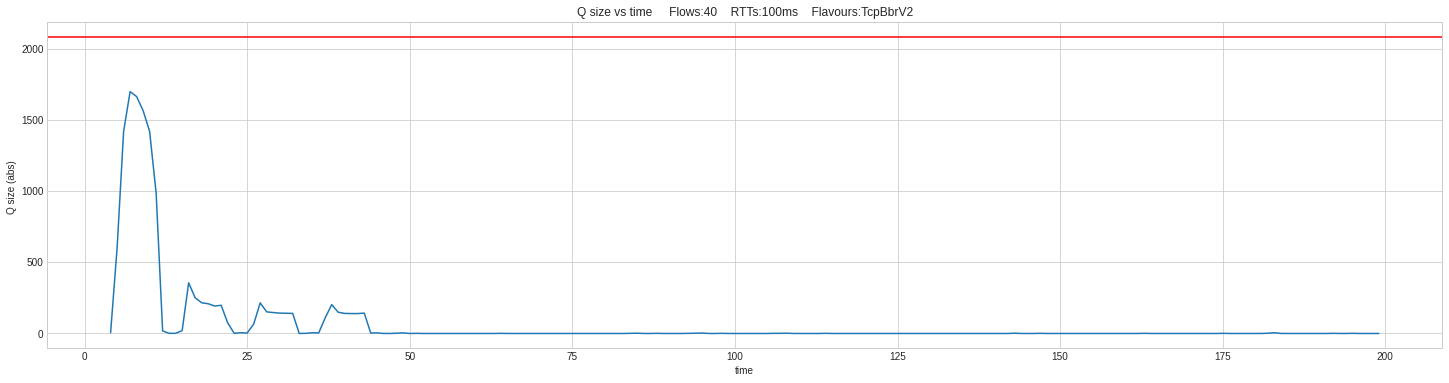

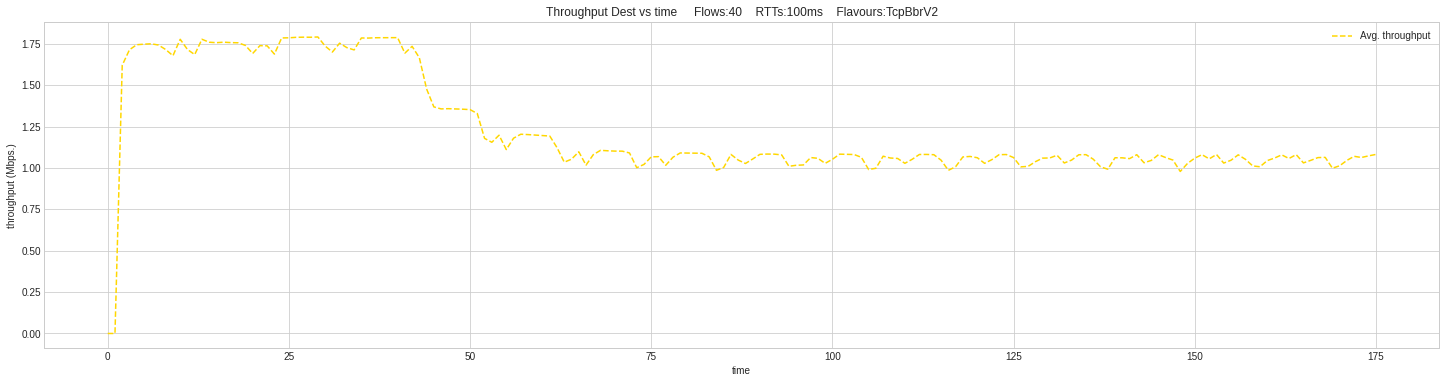

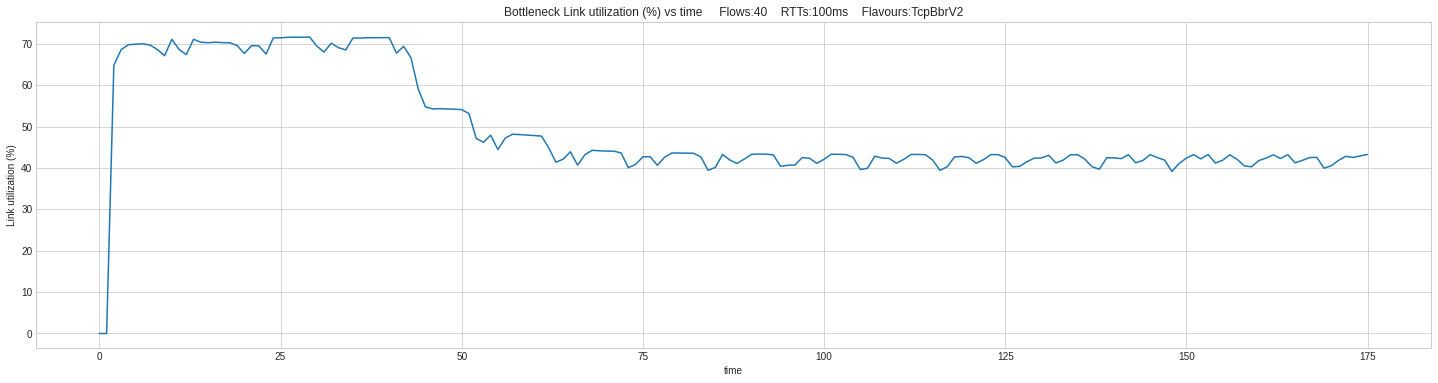

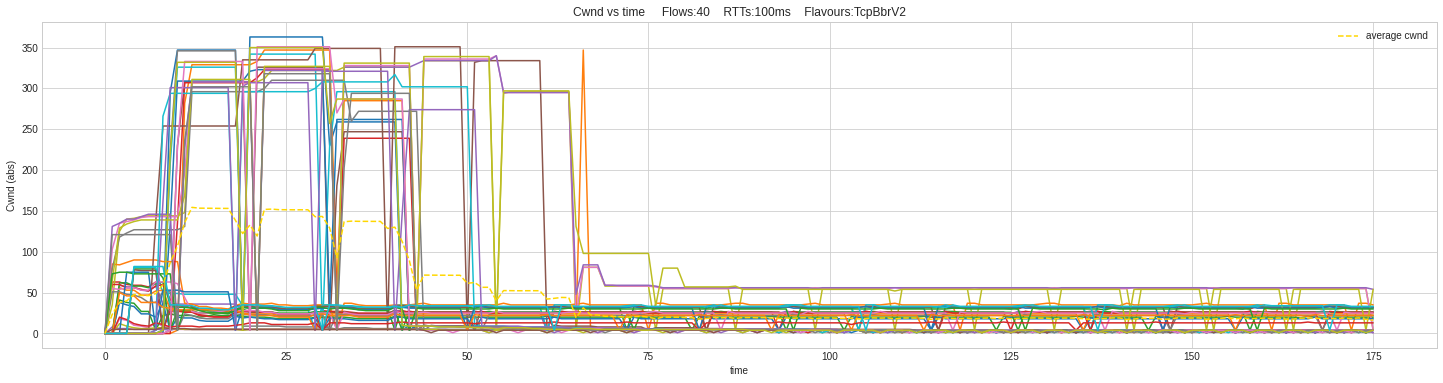

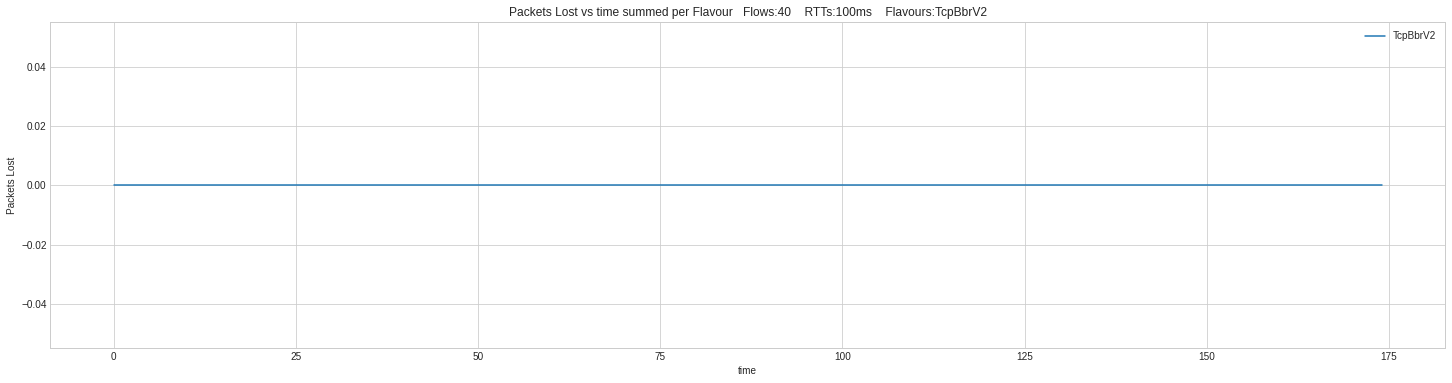

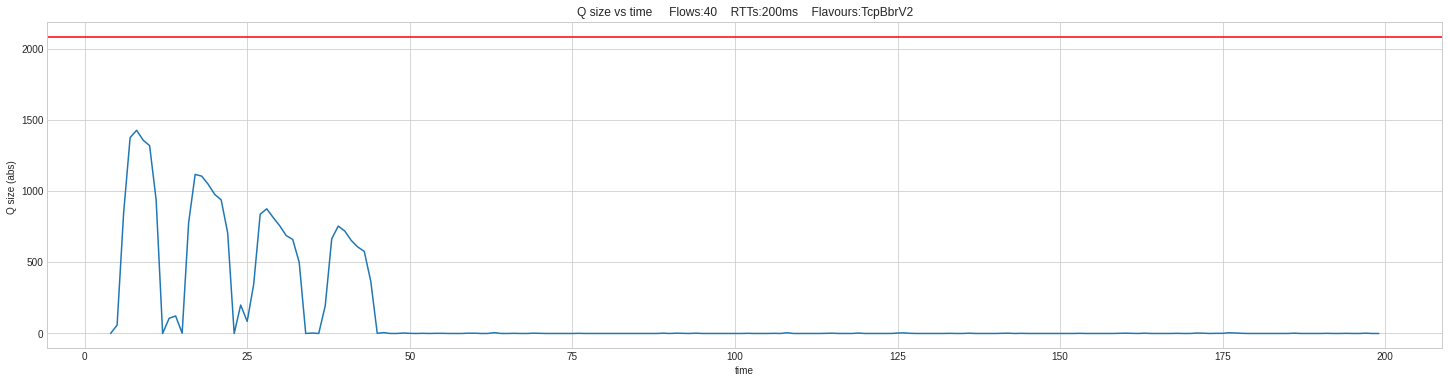

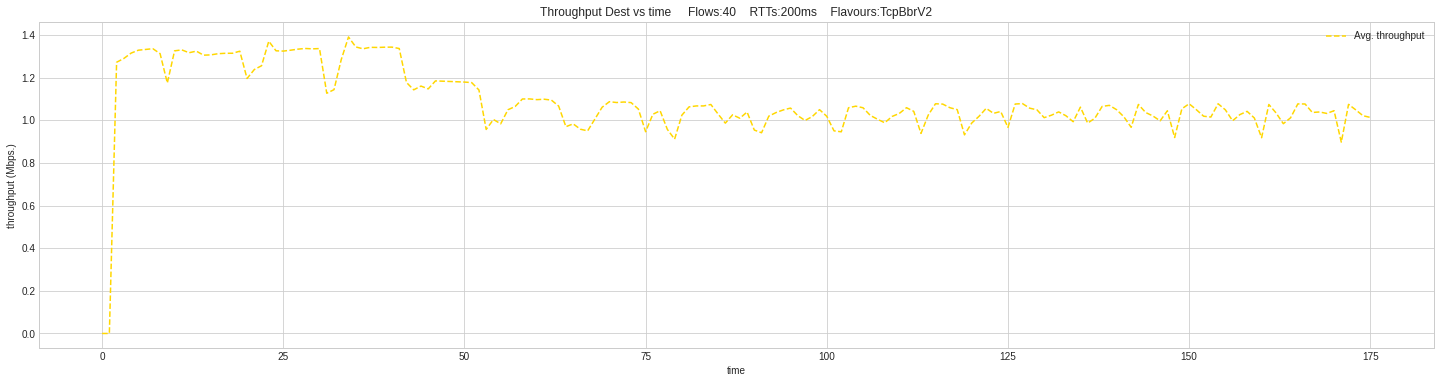

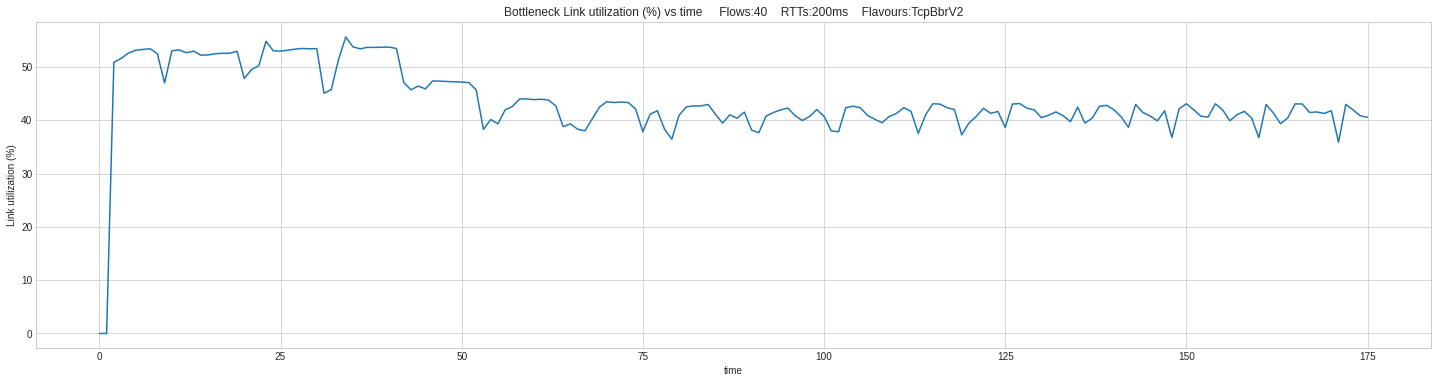

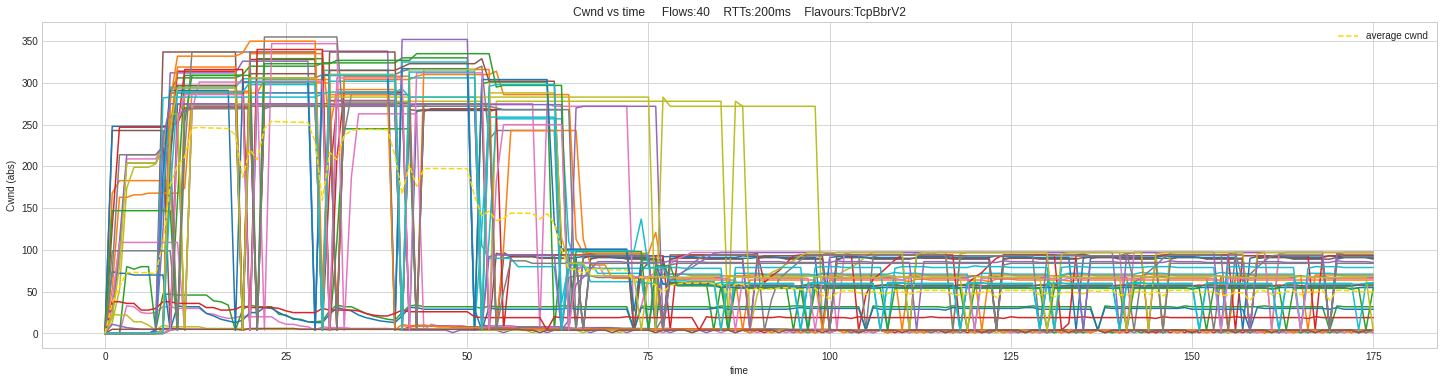

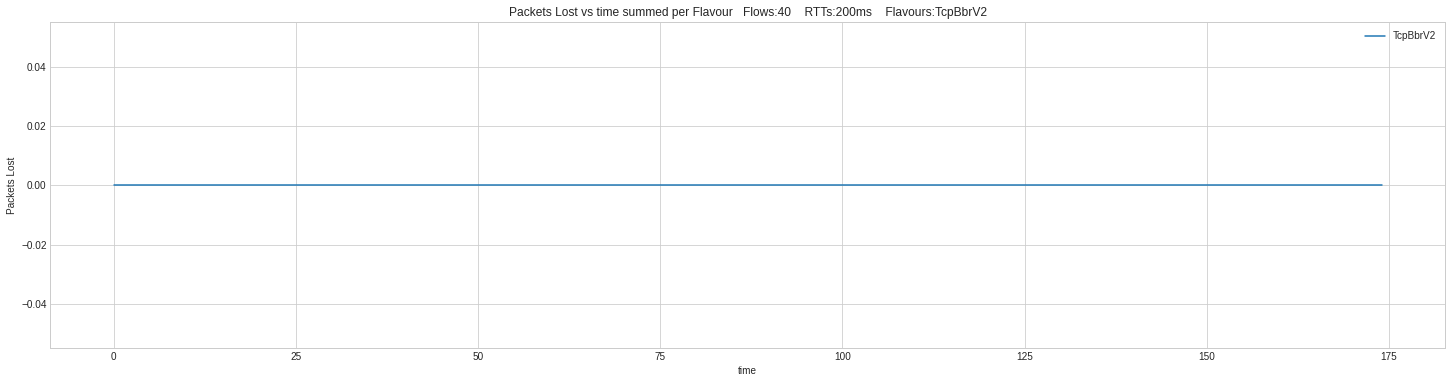

In [5]:
pktSize = 1400
RTTs = ["10ms", "100ms", "200ms"]
noOfSource = [40]
for rtt in RTTs:
     for n in noOfSource:
          main(Flavours = "TcpBbrV2", 
               time = 200, 
               noOfSource = n, 
               total_access_bandwidth = "120Mbps", 
               RTTs = rtt,
               bottleneck_bandwidth = "100Mbps",
               bottleneck_delay = "1ms", 
               packetSize = pktSize, 
               queueL = "2084p", 
               log_scale=0, 
               run_simul = "no",
               part = 0,
               build_profile = "optimized"
               )

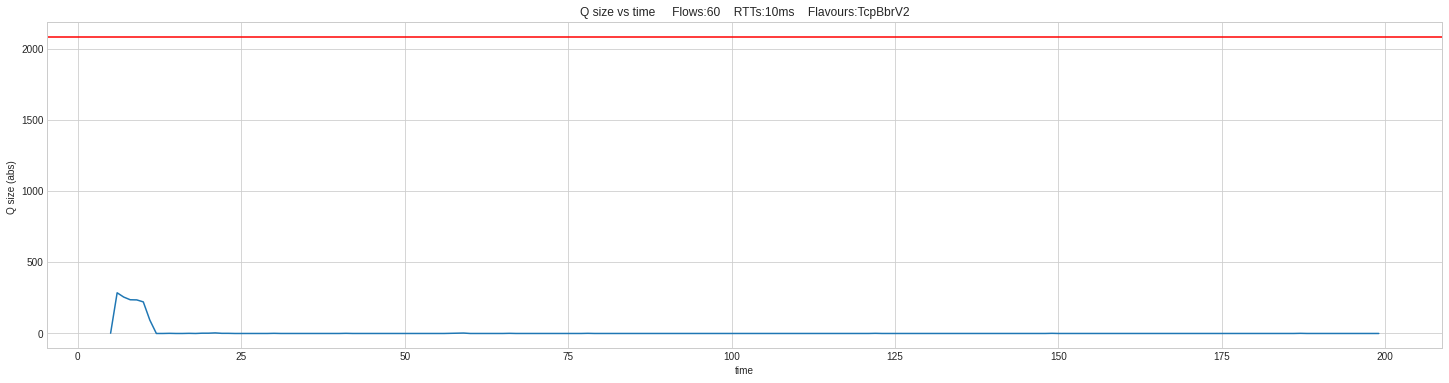

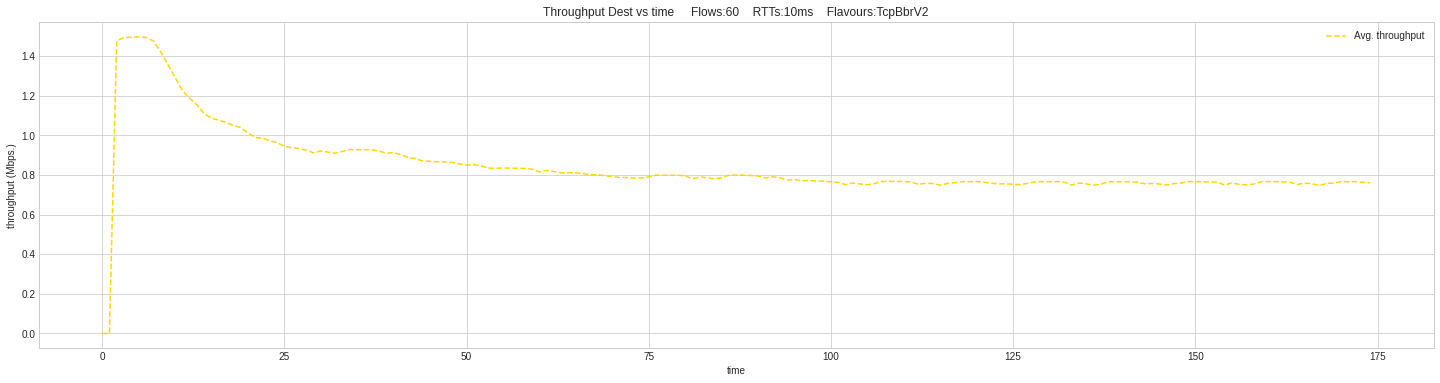

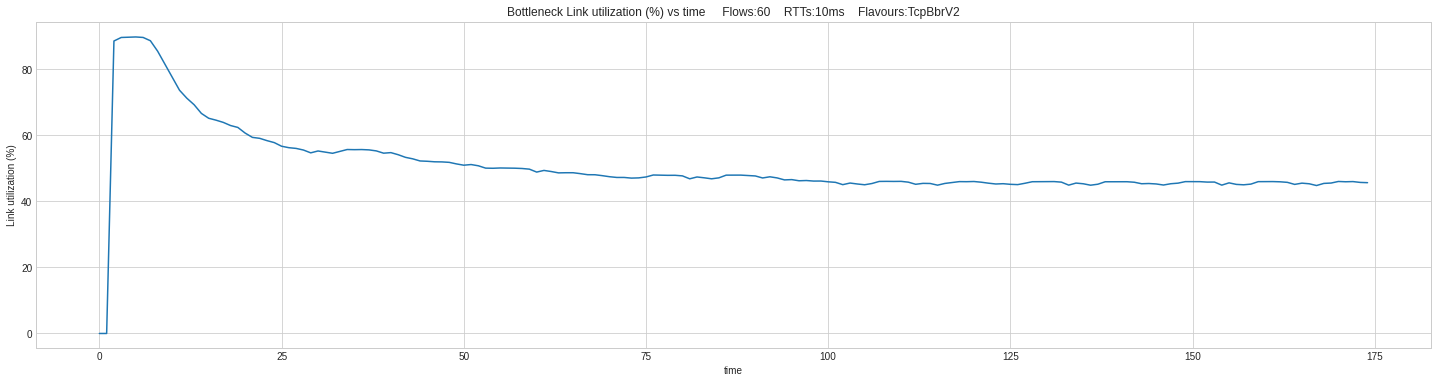

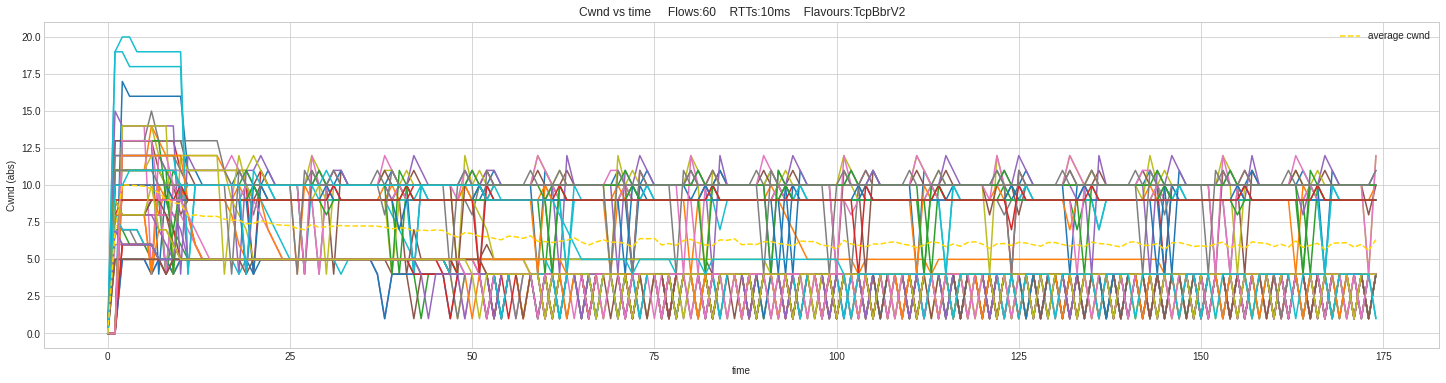

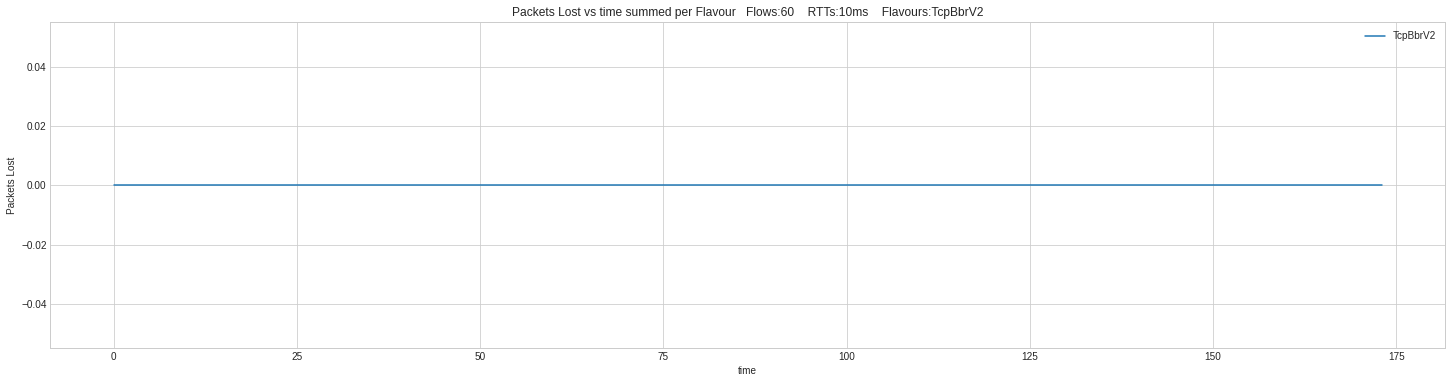

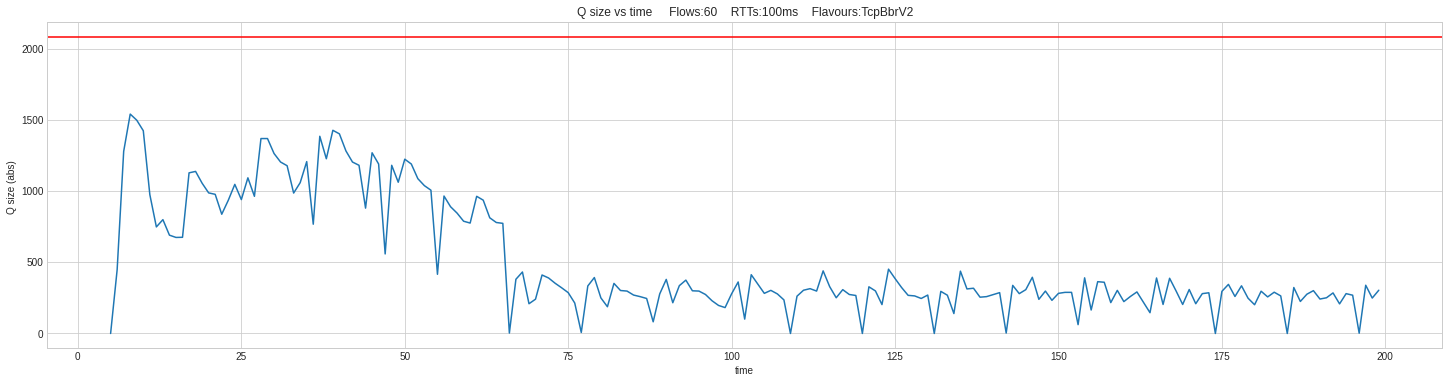

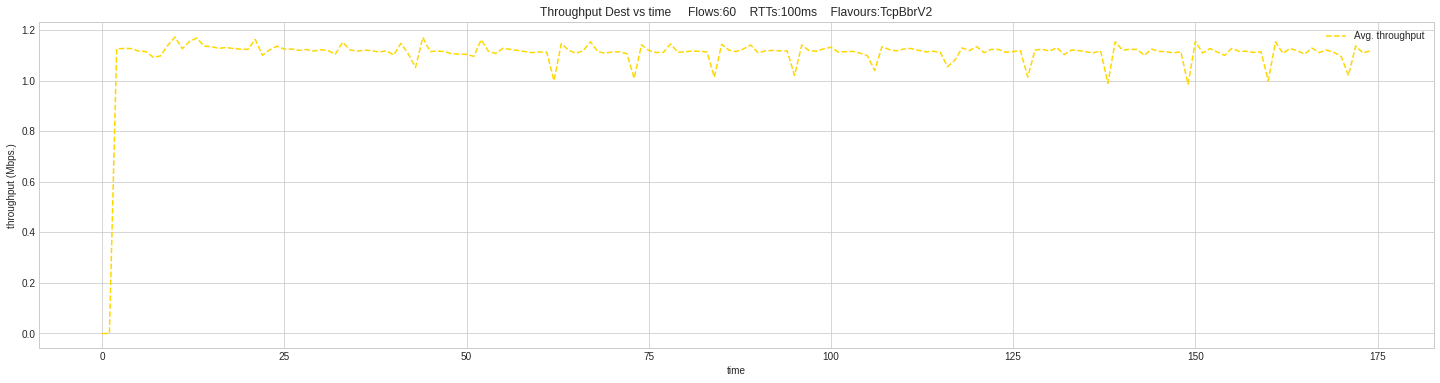

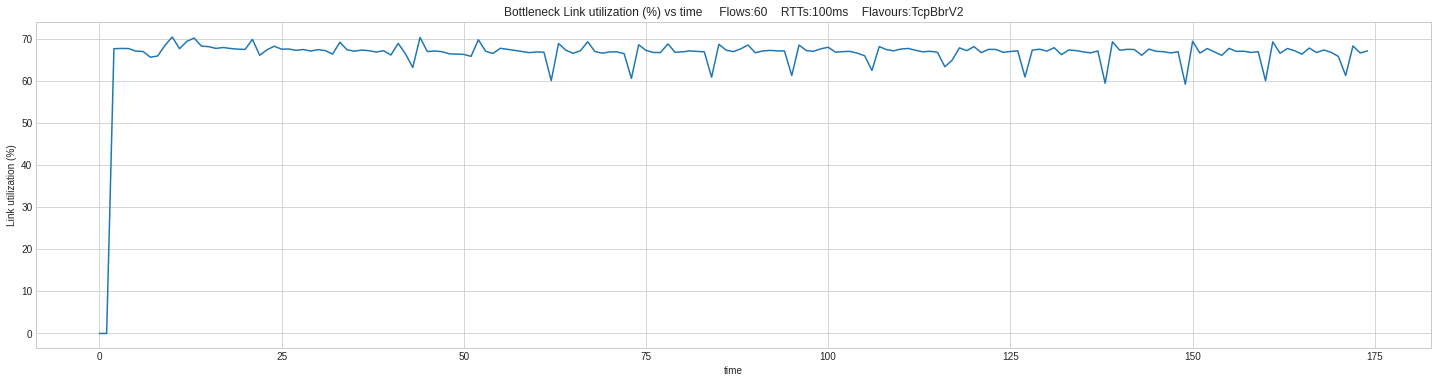

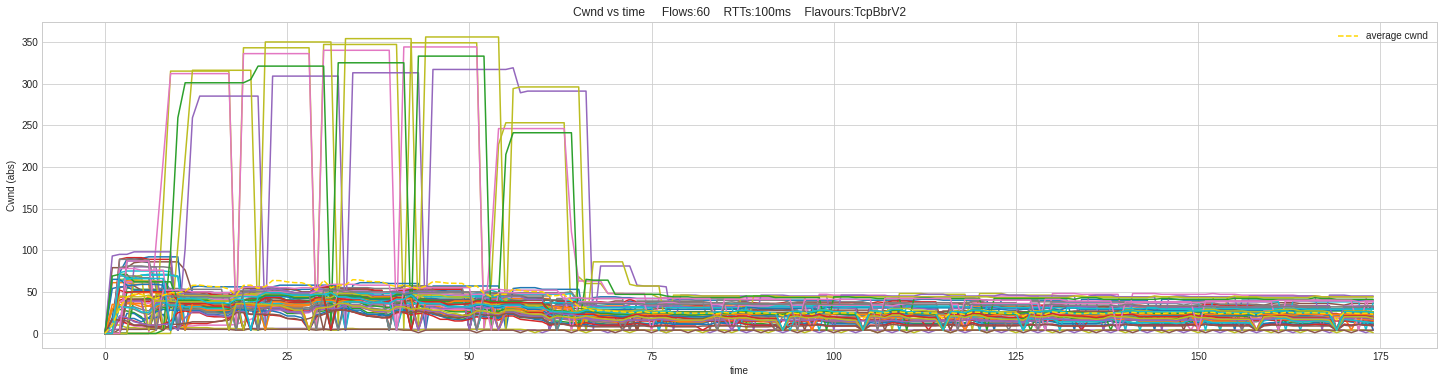

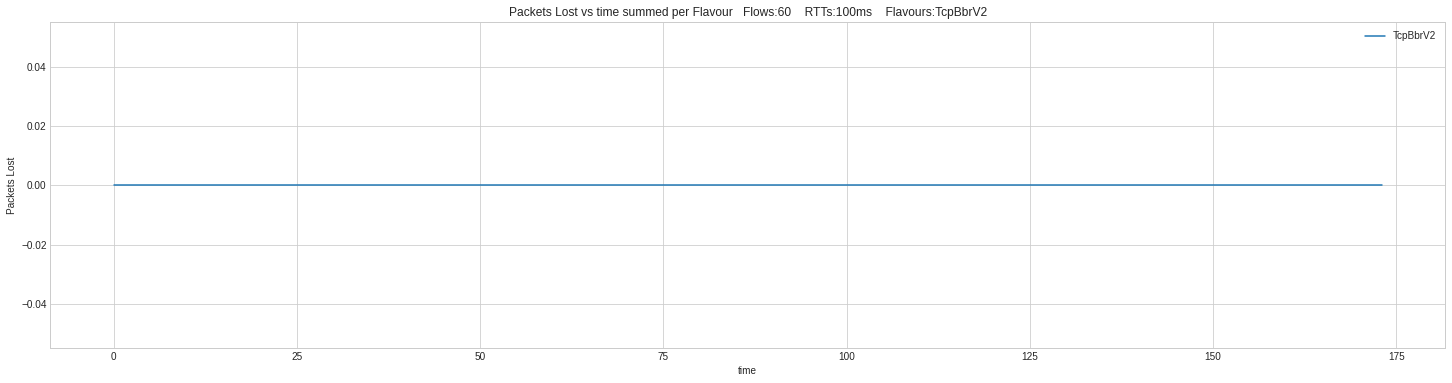

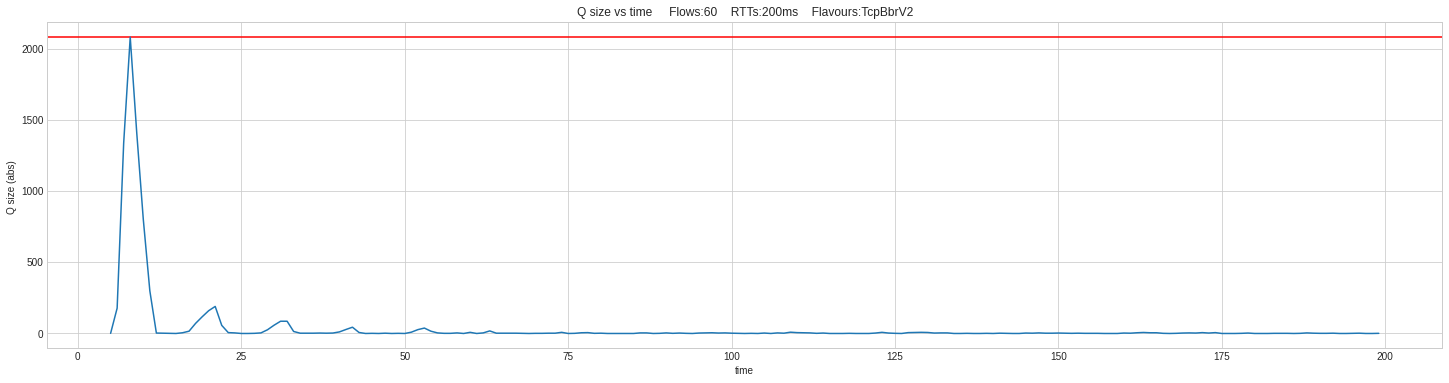

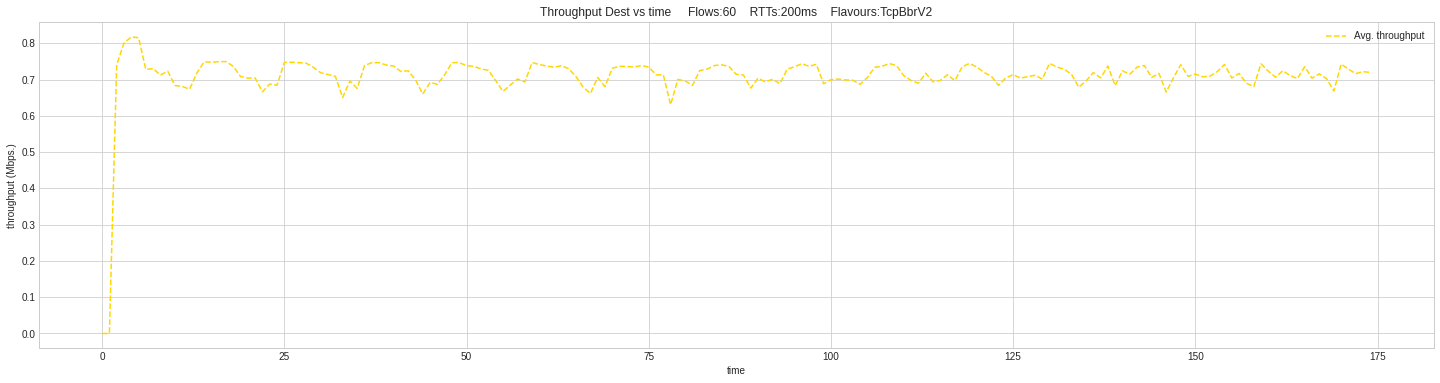

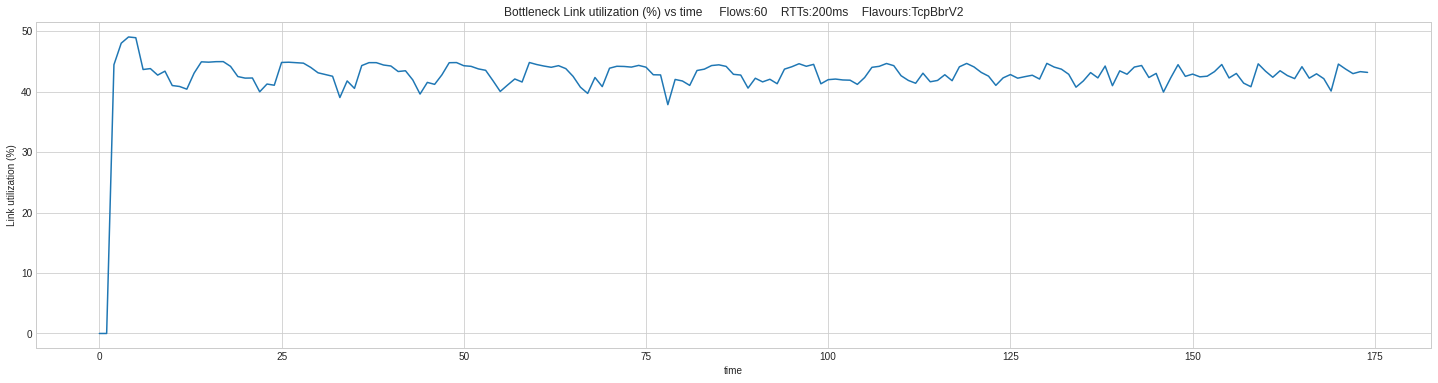

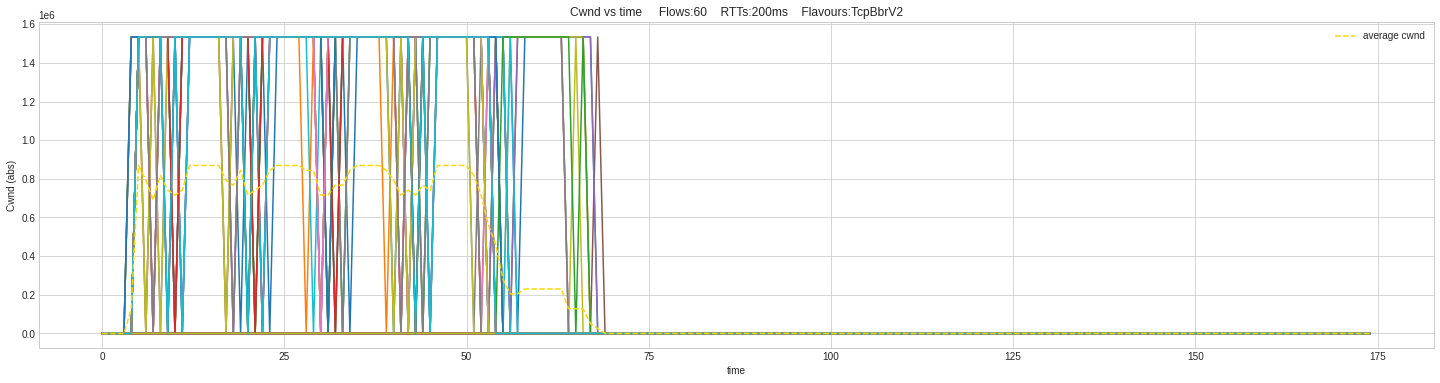

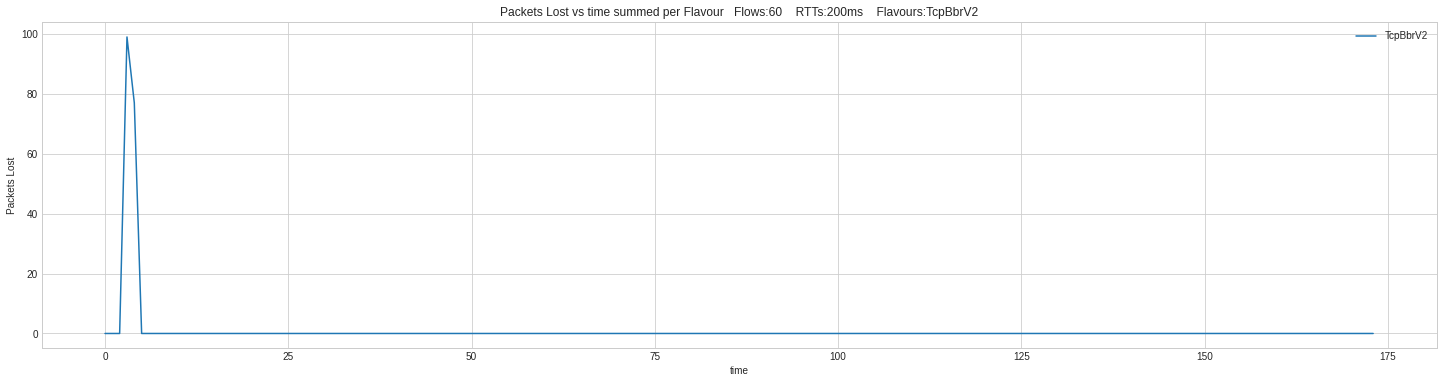

In [6]:
pktSize = 1400
RTTs = ["10ms", "100ms", "200ms"]
noOfSource = [60]
for rtt in RTTs:
     for n in noOfSource:
          main(Flavours = "TcpBbrV2", 
               time = 200, 
               noOfSource = n, 
               total_access_bandwidth = "120Mbps", 
               RTTs = rtt,
               bottleneck_bandwidth = "100Mbps",
               bottleneck_delay = "1ms", 
               packetSize = pktSize, 
               queueL = "2084p", 
               log_scale=0, 
               run_simul = "no",
               part = 0,
               build_profile = "optimized"
               )

In [7]:
pktSize = 1400
RTTs = ["10ms", "100ms", "200ms"]
noOfSource = [70]
for rtt in RTTs:
     for n in noOfSource:
          main(Flavours = "TcpBbrV2", 
               time = 200, 
               noOfSource = n, 
               total_access_bandwidth = "120Mbps", 
               RTTs = rtt,
               bottleneck_bandwidth = "100Mbps",
               bottleneck_delay = "1ms", 
               packetSize = pktSize, 
               queueL = "2084p", 
               log_scale=0, 
               run_simul = "yes",
               part = 0,
               build_profile = "debug"
               )

[0/2] Re-checking globbed directories...
ninja: no work to do.
Tracing CWND
Command 'build/scratch/ns3.36.1-tcp_ftp_n_rtts-debug --nSources=70 --flavours=TcpBbrV2 --bottleneckBandwidth=100Mbps --bottleneckDelay=1ms --accessBandwidth=1.7142857142857142Mbps --queueSize=2084p --pktSize=1400 --simDuration=200 --rtts=10ms --disableCwndTracing=False' died with <Signals.SIGSEGV: 11>.
[0/2] Re-checking globbed directories...
ninja: no work to do.
Tracing CWND
Command 'build/scratch/ns3.36.1-tcp_ftp_n_rtts-debug --nSources=70 --flavours=TcpBbrV2 --bottleneckBandwidth=100Mbps --bottleneckDelay=1ms --accessBandwidth=1.7142857142857142Mbps --queueSize=2084p --pktSize=1400 --simDuration=200 --rtts=100ms --disableCwndTracing=False' died with <Signals.SIGSEGV: 11>.
[0/2] Re-checking globbed directories...
ninja: no work to do.
Tracing CWND
